# Download Dataset

In [ ]:
import gdown
import zipfile
import os

# link from github
google_drive_link = 'https://drive.google.com/file/d/10uS02Hc1iPVmCPu2n99M3qSoS0L6lNzF/view?usp=sharing'

# Extract the file ID from the link
file_id = google_drive_link.split('/')[-2]

# Create the direct download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Define the output file path
output_path = '/content/downloaded_file.zip'

# Download the file
gdown.download(download_url, output_path, quiet=False)

# Verify the download
if os.path.exists(output_path):
    print("File downloaded successfully.")

    # Unzip the file
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset_fix')
    print("File unzipped successfully.")
else:
    print("Failed to download the file.")


Downloading...
From (original): https://drive.google.com/uc?id=10uS02Hc1iPVmCPu2n99M3qSoS0L6lNzF
From (redirected): https://drive.google.com/uc?id=10uS02Hc1iPVmCPu2n99M3qSoS0L6lNzF&confirm=t&uuid=19246d5b-489a-4562-9933-5c3af9b686da
To: /content/downloaded_file.zip
100%|██████████| 334M/334M [00:04<00:00, 81.8MB/s]


File downloaded successfully.
File unzipped successfully.


In [ ]:
import os

# Define the directory path
directory_path = '/content/dataset_fix'

# List all the entries in the directory
entries = os.listdir(directory_path)

# Filter out only directories
folders = [entry for entry in entries if os.path.isdir(os.path.join(directory_path, entry))]

# Get the number of folders
num_folders = len(folders)

# Print the number of folders and their names
print(f'The number of folders in "{directory_path}" is: {num_folders}')
print("Folder names:")
for folder in folders:
    print(folder)


The number of folders in "/content/dataset_fix" is: 14
Folder names:
Strawberry___Leaf_scorch
Tomato__Tomato_mosaic_virus
Tomato_healthy
Tomato_Septoria_leaf_spot
Tomato_Early_blight
Tomato_Bacterial_spot
Tomato__Target_Spot
Strawberry___healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Leaf_Mold
Tomato_Late_blight
Tomato__Tomato_YellowLeaf__Curl_Virus
Pepper__bell___healthy
Pepper__bell___Bacterial_spot


## Delete some ipynb checkpoint

In [ ]:
import os
import shutil

# Define the root directory path
root_directory = '/content/dataset_fix'

# Walk through the directory
for root, dirs, files in os.walk(root_directory):
    for dir_name in dirs:
        if dir_name == '.ipynb_checkpoints':
            # Construct the full path to the .ipynb_checkpoints directory
            dir_path = os.path.join(root, dir_name)
            # Delete the directory
            shutil.rmtree(dir_path)
            print(f'Deleted: {dir_path}')


Deleted: /content/dataset_fix/Tomato_Early_blight/.ipynb_checkpoints
Deleted: /content/dataset_fix/Pepper__bell___Bacterial_spot/.ipynb_checkpoints


# Import Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import time

## Check libraries

In [ ]:
# List of libraries to check
libraries = [
    "numpy",
    "pandas",
    "tensorflow",
    "cv2", # This is for OpenCV
    "matplotlib",
    "tensorflow_hub"
]

# Function to check if a library is installed
def check_library(lib):
    try:
        import subprocess
        result = subprocess.run(["pip", "show", lib], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            print(f"{lib} is installed.")
        else:
            print(f"{lib} is not installed.")
    except Exception as e:
        print(f"An error occurred while checking {lib}: {str(e)}")

# Check each library
for lib in libraries:
    check_library(lib)


numpy is installed.
pandas is installed.
tensorflow is installed.
cv2 is not installed.
matplotlib is installed.
tensorflow_hub is installed.


# Preproccesing data

## Create the label list and train dataset

In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
                 'Tomato_Bacterial_spot', 'Tomato_Early_blight','Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite',
                 'Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus','Tomato_healthy']

data_dir = '/content/dataset_fix'
train_dir = os.path.join(data_dir)

## looking for head of train dataset

In [ ]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(5)

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/78dbe7fe-0821-4c...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/fc45e7eb-9b7f-43...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/9728896c-149f-41...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/a663a181-328d-49...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/b34f18ca-799f-42...,0,Pepper__bell___Bacterial_spot


In [ ]:
list_kelas = train[['DiseaseID', 'Disease Type']].drop_duplicates()

# Urutkan DataFrame list_kelas berdasarkan DiseaseID
list_kelas = list_kelas.sort_values(by='DiseaseID').reset_index(drop=True)

# Tampilkan list_kelas
list_kelas.head(14)

,DiseaseID,Disease Type
0,0,Pepper__bell___Bacterial_spot
1,1,Pepper__bell___healthy
2,2,Strawberry___Leaf_scorch
3,3,Strawberry___healthy
4,4,Tomato_Bacterial_spot
5,5,Tomato_Early_blight
6,6,Tomato_Late_blight
7,7,Tomato_Leaf_Mold
8,8,Tomato_Septoria_leaf_spot
9,9,Tomato_Spider_mites_Two_spotted_spider_mite


## Randomizing the Training Sample

In [ ]:
seed = 45
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,DiseaseID,Disease Type
8148,Tomato_Late_blight/2dd36c99-7454-499f-8ff5-d25...,6,Tomato_Late_blight
3656,Strawberry___healthy/06d4ec77-12ef-47ed-ab37-b...,3,Strawberry___healthy
14855,Tomato__Target_Spot/8f2a090d-92c1-4bf4-8806-a1...,10,Tomato__Target_Spot
17376,Tomato__Tomato_YellowLeaf__Curl_Virus/6075fa49...,11,Tomato__Tomato_YellowLeaf__Curl_Virus
4078,Tomato_Bacterial_spot/1e982ff7-1d2f-43e9-9c10-...,4,Tomato_Bacterial_spot


**Let's create Helper functions for visualizing diseases**

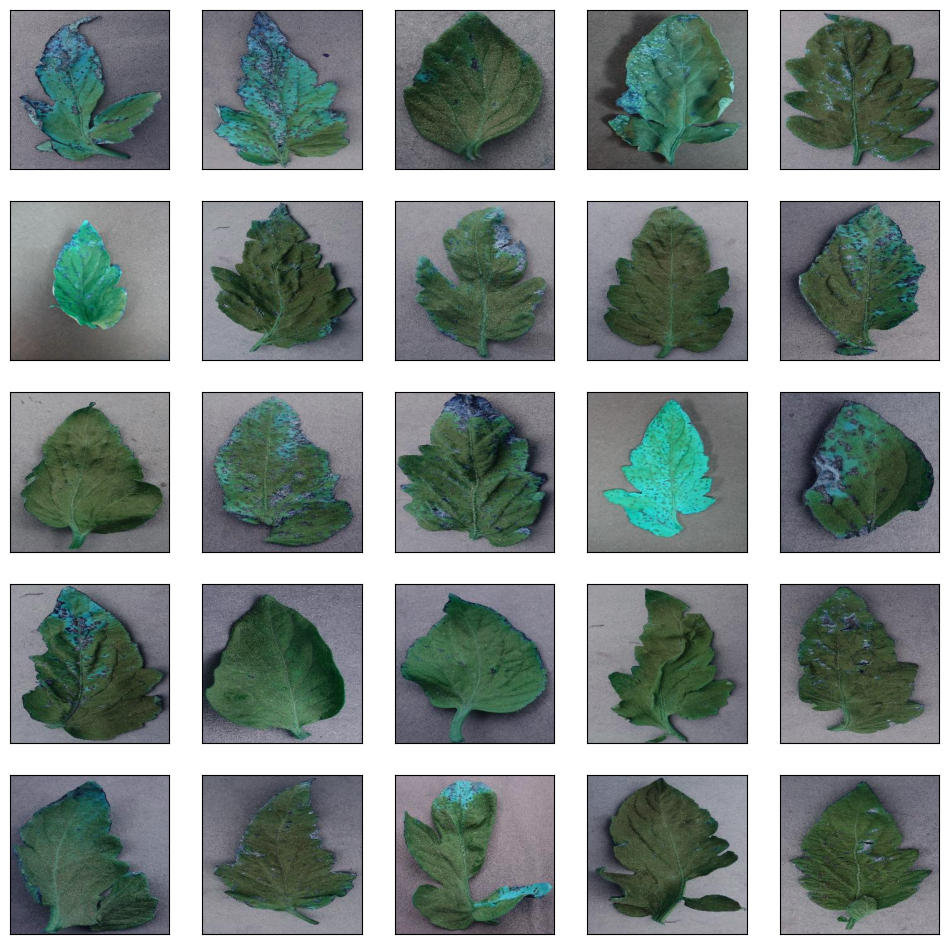

In [ ]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('Tomato_Bacterial_spot', 5, 5)

**Let's look at some healthy samples**

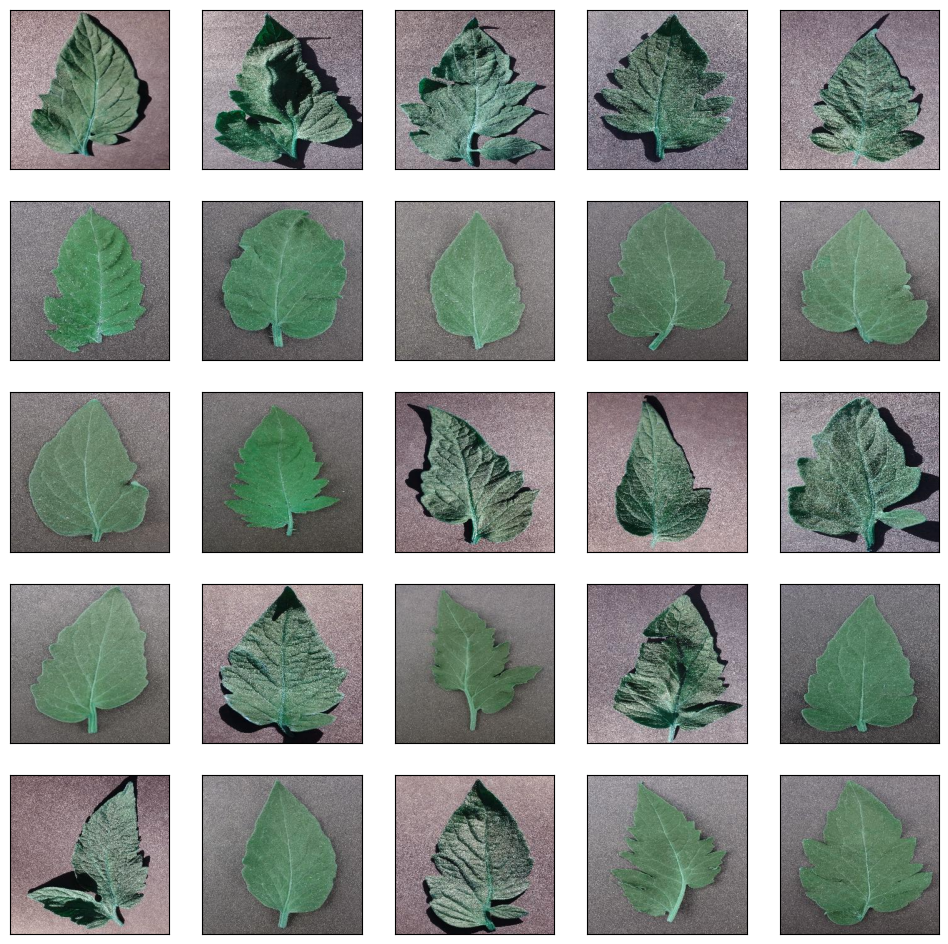

In [ ]:
disease_type('Tomato_healthy', 5, 5)

## Image Data Augmentation

In [ ]:
def create_image_data_generators(data_dir, image_size, batch_size, do_data_augmentation):
    # Inputs are suitably resized for the selected module.
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        data_dir,
        shuffle=False,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    if do_data_augmentation:
        # Enable data augmentation
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')
    else:
        # Disable data augmentation
        train_datagen = datagen

    # Train generator
    train_generator = datagen.flow_from_directory(
        train_dir,
        subset="training",
        shuffle=True,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    return train_generator, validation_generator

In [ ]:
data_dir = data_dir
train_dir = train_dir
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
do_data_augmentation = True
train_generator, validation_generator = create_image_data_generators(data_dir, IMAGE_SIZE, BATCH_SIZE, do_data_augmentation)

Found 20051 images belonging to 14 classes.
Found 16047 images belonging to 14 classes.


# Build Model

## Create Callbacks for easy maintenance while training

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

## Create custom plot

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


## Create module handle from tensorflow hub using inceptionv3

In [ ]:
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)

print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

## Create the model layers

In [ ]:
class_count = train_generator.num_classes
print(class_count)
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
model.summary()

14
Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 22339118 (85.22 MB

# Specifying Loss Functions

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 22339118 (85.22 MB)
Trainable params: 532238 (2.03 MB)
Non-trainable params: 21806880 (83.19 MB)
___________

## Set all hyper parameter and variabel for custom training

In [ ]:
batch_size = 40   # set batch size for training
epochs = 14   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(12 / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

## Start train the model

In [ ]:
history = model.fit(x= train_generator, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= validation_generator, validation_steps= validation_generator.samples // validation_generator.batch_size)

Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /15     5.744   79.149   3.19952  92.826   0.00100  0.00100  accuracy     0.00    168.07 
 2 /15     2.251   89.506   1.43458  93.540   0.00100  0.00100  accuracy    13.09    152.49 
 3 /15     1.211   90.933   0.89632  95.073   0.00100  0.00100  val_loss    37.52    145.99 
 4 /15     0.898   91.843   0.73268  95.477   0.00100  0.00100  val_loss    18.26    145.09 
 5 /15     0.786   92.304   0.66248  95.283   0.00100  0.00100  val_loss     9.58    145.44 
 6 /15     0.728   92.304   0.61023  95.917   0.00100  0.00100  val_loss     7.89    144.51 
 7 /15     0.689   92.952   0.58494  96.071   0.00100  0.00100  val_loss     4.14    146.39 
 8 /15     0.664   93.239   0.57105  96.031   0.00100  0.00100  val_loss     2.37    145.39 
 9 /15     0.643   93.239   0.55156  96.171   0.00100  0.00100  val_loss     3.41    145.61 
10 /15     0.

## Plot history using custom plot

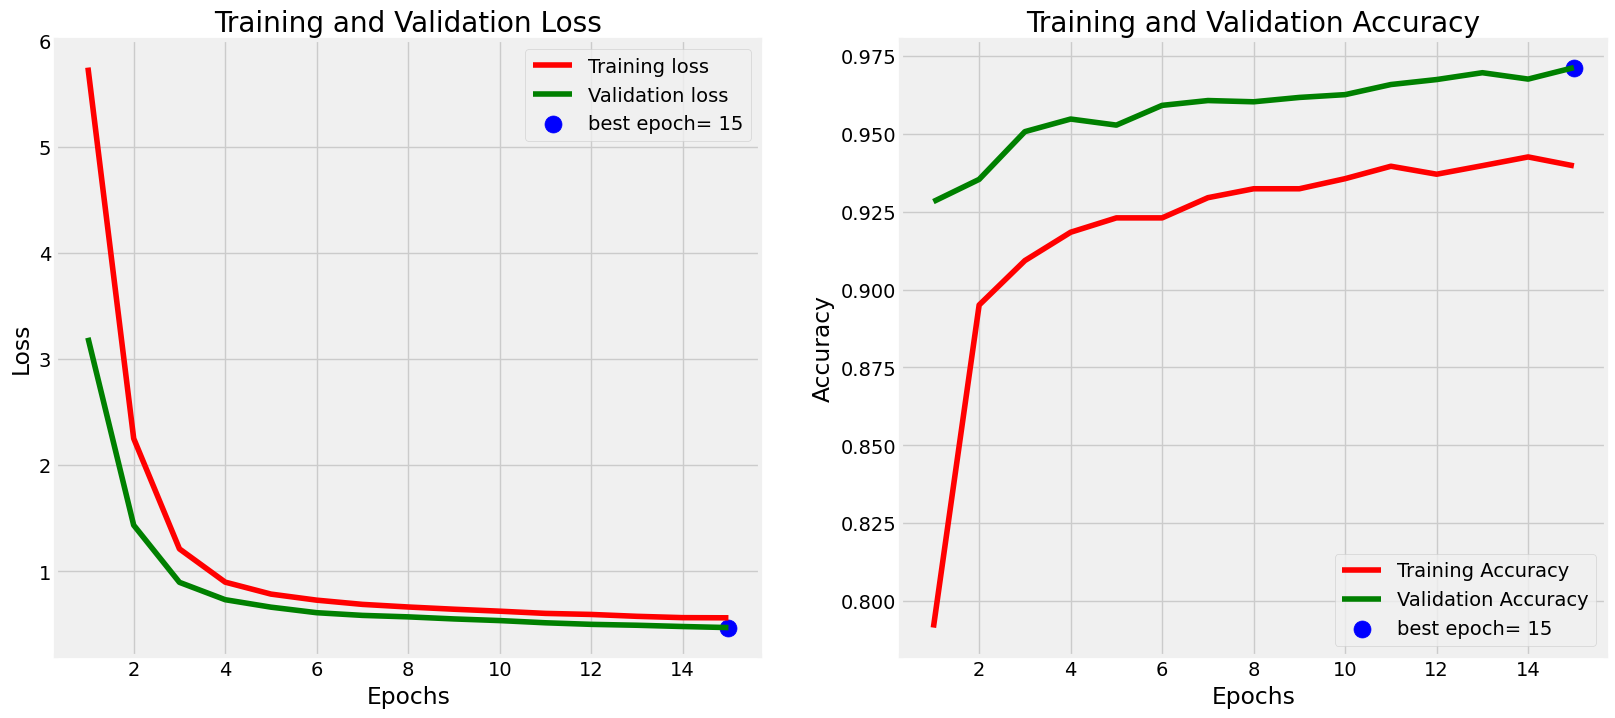

In [ ]:
plot_training(history)

# Evaluation

## Evaluation using validation generator from dataset split

In [ ]:
preds = model.predict(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

627/627 [==============================] - 88s 141ms/step


In [ ]:
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

## Confusion report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       976
           1       0.99      0.98      0.99      1495
           2       1.00      1.00      1.00      1112
           3       1.00      1.00      1.00       454
           4       0.98      0.98      0.98      2142
           5       0.89      0.94      0.92       946
           6       0.97      0.97      0.97      1922
           7       0.94      0.96      0.95       928
           8       0.96      0.97      0.96      1756
           9       0.96      0.95      0.96      1696
          10       0.94      0.91      0.93      1444
          11       1.00      0.99      0.99      3221
          12       0.97      0.97      0.97       374
          13       0.98      0.99      0.98      1585

    accuracy                           0.97     20051
   macro avg       0.97      0.97      0.97     20051
weighted avg       0.97      0.97      0.97     20051



## Confusion matrix

Text(0.5, 160.08333333333326, 'Predicted')

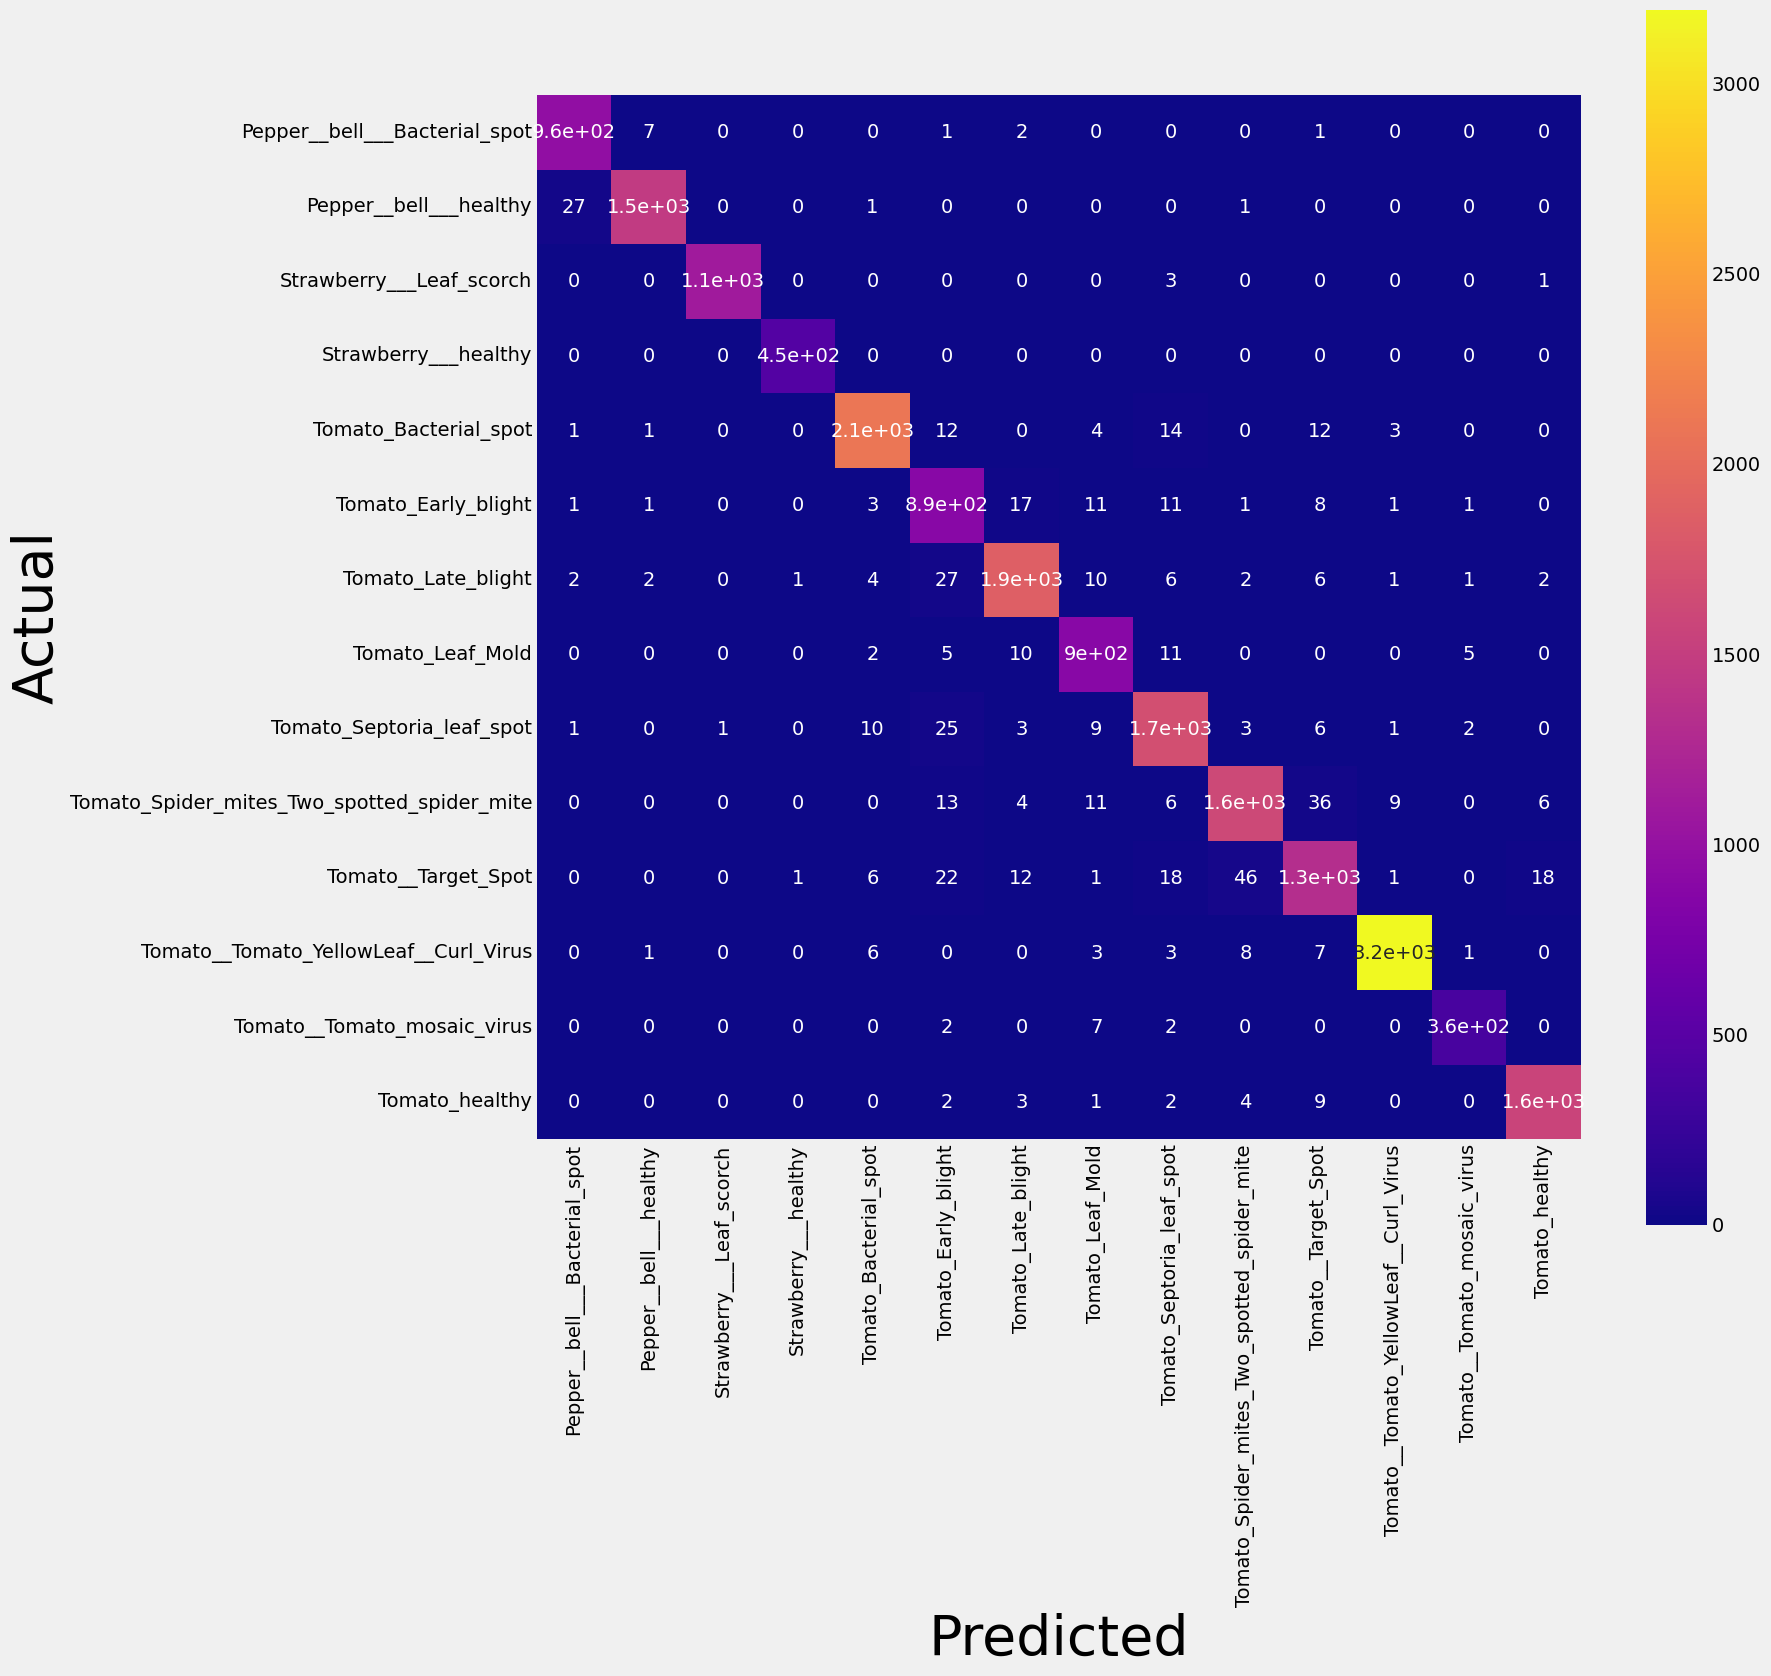

In [ ]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Image testing

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (299, 299))
    img = img / 255.0  # Normalisasi nilai piksel
    return img


    return img
def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)

    return {disease_types[class_idx]: probabilities[class_idx]}


1/1 [==============================] - 0s 38ms/step
Predicted class: Tomato_healthy, confidence: 0.990575


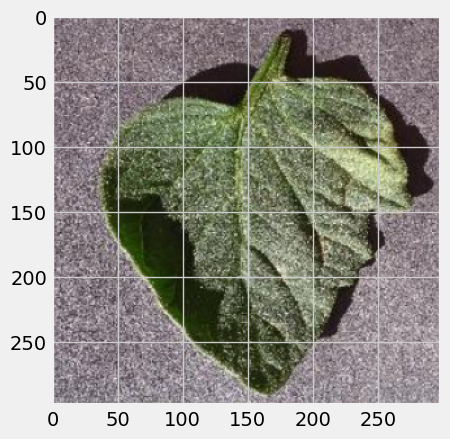

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import os

def is_url(path_or_url):
    return path_or_url.startswith('http://') or path_or_url.startswith('https://')

def load_image(path_or_url):
    if is_url(path_or_url):
        # Download the image from the URL
        response = requests.get(path_or_url)
        img = np.array(Image.open(BytesIO(response.content)))
    else:
        # Load the image from a local file path
        img = cv2.imread(path_or_url)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    img = cv2.resize(img, (299, 299))
    img = img / 255.0  # Normalize pixel values
    return img

# Load a single image
img_path_or_url = 'https://raw.githubusercontent.com/WasiatD/MachineLearning/main/dataset/Image-test/TomatoHealthy1.JPG'
img = load_image(img_path_or_url)

# Predict the class of the image
prediction = predict(img)

# Print the prediction
print("Predicted class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

# Show the image
plt.imshow(img)
plt.show()


# Converting to Tensorflow and TF-Lite

## Tensorflow

In [ ]:
from google.colab import files
path = "/content/model_fix"
tf.saved_model.save(model, path)

# Name for the ZIP file
zip_file_name = 'model-fix'

# Create a ZIP file
shutil.make_archive(zip_file_name, 'zip', path)

'/content/model-fix.zip'

In [ ]:
from google.colab import files
files.download('/content/model-fix.zip') # save this mode then extract the zip file, the folder is for model in loaded_model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_names = [
    "Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
    "Strawberry___Leaf_scorch", "Strawberry___healthy",
    "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
    "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato__Target_Spot",
    "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus", "Tomato_healthy"
]


### How to use Tensorflow

In [ ]:
# Load the TensorFlow SavedModel
loaded_model = tf.saved_model.load(path)

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Function to check if the input is a URL
def is_url(path_or_url):
    return path_or_url.startswith('http://') or path_or_url.startswith('https://')

# Function to load image from a file path or URL
def load_image(path_or_url):
    if is_url(path_or_url):
        # Download the image from the URL
        response = requests.get(path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        # Load the image from a local file path
        img = Image.open(path_or_url)

    img = img.resize((299, 299))  # Resize the image to match model input size
    img_array = np.array(img)  # Convert image to numpy array
    img_array = img_array.astype(np.float32) / 255.0  # Normalize pixel values and convert to float32
    return np.expand_dims(img_array, axis=0)  # Expand dimensions to match input shape of the model

img_path_or_url = 'https://raw.githubusercontent.com/WasiatD/MachineLearning/main/dataset/Image-test/TomatoYellowCurlVirus1.JPG'
img = load_image(img_path_or_url)

# Predict the class of the image using the loaded_model directly
prediction = loaded_model(img)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)
# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the predicted class name
print("Predicted class name:", predicted_class_name)


Predicted class name: Tomato__Tomato_YellowLeaf__Curl_Virus


## TF-Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 87172KBs.


In [ ]:
 # Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))


Quantized model size = 22107KBs,
which is about 25% of the float model size.


In [ ]:
f = open('plant_model.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

### How to use TF-lite

In [ ]:
tflite_model_path = "/content/plant_model.tflite"  # Ganti dengan path ke model TensorFlow Lite Anda
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


In [ ]:
import requests
from urllib.parse import urlparse

# Check if the input is a URL or local file
img_url = '/content/TomatoEarlyBlight2.JPG'

# Function to check if a string is a valid URL
def is_url(string):
    parsed = urlparse(string)
    return all([parsed.scheme, parsed.netloc])

# Load image based on input type
if is_url(img_url):
    response = requests.get(img_url)
    image = tf.keras.preprocessing.image.load_img(BytesIO(response.content), target_size=(299, 299))
else:
    image = tf.keras.preprocessing.image.load_img(img_url, target_size=(299, 299))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0  # Normalisasi gambar input


In [ ]:
input_index = interpreter.get_input_details()[0]['index']
interpreter.set_tensor(input_index, input_arr)


In [ ]:
interpreter.invoke()


In [ ]:
output_index = interpreter.get_output_details()[0]['index']
output = interpreter.get_tensor(output_index)
predicted_class_index = np.argmax(output)
predicted_class_name = class_names[predicted_class_index]
print(predicted_class_index)
print("Predicted class:", predicted_class_name)

5
Predicted class: Tomato_Early_blight


In [ ]:
from google.colab import files

# Tentukan path file yang ingin diunduh
file_path = "/content/plant_model.tflite"

# Unduh file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate information using GeminiAPI

### Upload model

In [ ]:
from google.colab import files

model_path = files.upload()

In [ ]:
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
model = genai.GenerativeModel('gemini-pro')

In [ ]:
response = model.generate_content("Hello")
print(response.text)

Hello there! How can I assist you today?


## Implementation Tf-Lite model dan gemini

In [ ]:
def predict_image(model_path, image_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Load image and preprocess
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.expand_dims(input_arr, axis=0)
    input_arr = input_arr / 255.0  # Normalize the input image

    # Set input tensor
    input_index = interpreter.get_input_details()[0]['index']
    interpreter.set_tensor(input_index, input_arr)

    # Invoke interpreter
    interpreter.invoke()

    # Get output tensor and predicted class
    output_index = interpreter.get_output_details()[0]['index']
    output = interpreter.get_tensor(output_index)
    predicted_class_index = np.argmax(output)

    class_names = [
        "Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
        "Strawberry___Leaf_scorch", "Strawberry___healthy",
        "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
        "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
        "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato__Target_Spot",
        "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus",
        "Tomato_healthy"
    ]

    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

In [ ]:
def prompt_disease(disease):
    # Dapatkan kunci API Google Anda dari userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

    # Konfigurasi kunci API
    genai.configure(api_key=GOOGLE_API_KEY)

    # Buat instance model GenerativeModel untuk Gemini
    model = genai.GenerativeModel('gemini-pro')

    # Prompt berdasarkan penyakit
    prompt = f"Jelaskan Penyakit {disease}: Pengertian, Penyebab, dan Cara Penanganan singkat dalam 3 paragraf."

    # Gunakan model untuk menghasilkan konten berdasarkan prompt
    response = model.generate_content(prompt)

    # Cetak hasil konten yang dihasilkan
    return response.text


In [ ]:
def main():
    model_path = "/content/plant_model.tflite"
    image_path = "/TomatoYellowCurlVirus1.JPG"
    predicted_class = predict_image(model_path, image_path)
    print(prompt_disease(predicted_class))

if __name__ == "__main__":
    main()


**Pengertian**

Tomato Yellow Leaf Curl Virus (TYLCV) adalah penyakit virus yang menyerang tanaman tomat. Virus ini menyebabkan daun menguning, keriting, dan kerdil, sehingga menghambat pertumbuhan dan produksi buah.

**Penyebab**

TYLCV disebabkan oleh virus yang ditularkan oleh kutu kebul (Bemisia tabaci). Kutu kebul membawa virus dari tanaman yang terinfeksi ke tanaman yang sehat melalui tusukan saat mencari makan.

**Cara Penanganan**

Penanganan TYLCV melibatkan:

* Pencegahan: Menggunakan varietas tomat yang tahan, mengontrol populasi kutu kebul, dan menanam tanaman penutup untuk mengusir kutu kebul.
* Pengobatan: Tidak ada pengobatan kimia yang efektif untuk TYLCV. Tanaman yang terinfeksi harus dicabut dan dimusnahkan untuk mencegah penyebaran virus lebih lanjut.
* Manajemen Hama: Mengendalikan populasi kutu kebul menggunakan insektisida atau metode pengendalian hama alami seperti predator dan parasitoid.


## Implementation Tensorflow model dan gemini

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

def predict_tf(img_path, loaded_model):
    class_names = [
        "Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
        "Strawberry___Leaf_scorch", "Strawberry___healthy",
        "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
        "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
        "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato__Target_Spot",
        "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus",
        "Tomato_healthy"
    ]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((299, 299))  # Resize the image to match model input size
    img_array = np.array(img)  # Convert image to numpy array
    img_array = img_array.astype(np.float32) / 255.0  # Normalize pixel values and convert to float32

    # Predict the class of the image using the loaded_model directly
    prediction = loaded_model(np.expand_dims(img_array, axis=0))

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name



In [ ]:
def main_tf():
    # Load the TensorFlow SavedModel
    loaded_model = tf.saved_model.load(model_path)

    # Load the image and predict the class
    predicted_class_name = predict_tf(image_path, loaded_model)

    # Print the predicted class name
    print(prompt_disease(predicted_class_name))

if __name__ == "__main__":
    model_path = "/content/model_fix"
    image_path = "/TomatoYellowCurlVirus1.JPG"
    main_tf()


**Pengertian**

Tomato Yellow Leaf Curl Virus (TYLCV) adalah penyakit virus yang umum menyerang tanaman tomat, menyebabkan kerugian besar pada hasil panen. Infeksi virus ini ditandai dengan gejala khas berupa keriting dan menguningnya daun, serta pertumbuhan tanaman yang terhambat.

**Penyebab**

TYLCV disebabkan oleh virus Begomovirus yang ditularkan oleh kutu kebul (Bemisia tabaci). Kutu kebul ini memperoleh virus dari tanaman yang terinfeksi dan menularkannya ke tanaman sehat melalui tusukan makan pada daun. Lingkungan yang mendukung perkembangan kutu kebul, seperti suhu tinggi dan kelembapan rendah, dapat meningkatkan penyebaran penyakit.

**Penanganan**

Penanganan TYLCV berfokus pada pencegahan dan pengendalian kutu kebul. Petani dapat menggunakan penutup tanaman untuk melindungi tanaman dari kutu kebul, serta menggunakan insektisida untuk mengendalikan populasi kutu kebul. Praktik budidaya yang baik, seperti sanitasi lahan dan rotasi tanaman, juga dapat membantu mengurangi risik

# Closing

During this session, we successfully:

1.   Data Preparation: Cleaned and preprocessed our dataset, ensuring it was ready for effective model training.
2.   Model Training: Utilized the InceptionV3 model to harness transfer learning, achieving promising initial results.
3. Model Deployment: Discussed deploying our model using FastAPI and Cloud Run for scalability and accessibility.

To further improve your models:


1.   Experiment with Hyperparameters: Adjust hyperparameters to improve training and validation accuracy.
2.   Refine Prompts: Work on generating better prompts for more accurate and reliable outputs.


Thank you all. We've made significant strides in training machine learning models using TensorFlow and TFHub, leveraging the powerful InceptionV3 model for transfer learning.
